In [1]:
import matplotlib.pyplot as plt

import h5py
import numpy as np
import pandas as pd
import torch

from collections import Counter

from torch.utils.data import ConcatDataset, DataLoader
from torch_geometric.data import DataListLoader

/g/g92/noh1/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import clear_output
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [3]:
os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /g/g92/noh1/fast2


In [4]:
data_dir = "./data/mpro"
data_name = "gmd_postera_protease_pos.h5"
affinity_name = "updated_mpro_positive_compounds.csv"

In [5]:
data_path = os.path.join(data_dir, data_name)
# print(os.path.exists(data_path))

df = h5py.File(data_path, 'r')
data_names = list(df)
print(len(data_names))
data_names[:15]

15010


['AAR-POS-0daf6b7e-23_protease_1',
 'AAR-POS-0daf6b7e-23_protease_10',
 'AAR-POS-0daf6b7e-23_protease_2',
 'AAR-POS-0daf6b7e-23_protease_3',
 'AAR-POS-0daf6b7e-23_protease_4',
 'AAR-POS-0daf6b7e-23_protease_5',
 'AAR-POS-0daf6b7e-23_protease_6',
 'AAR-POS-0daf6b7e-23_protease_7',
 'AAR-POS-0daf6b7e-23_protease_8',
 'AAR-POS-0daf6b7e-23_protease_9',
 'AAR-POS-5507155c-1_protease_1',
 'AAR-POS-5507155c-1_protease_10',
 'AAR-POS-5507155c-1_protease_2',
 'AAR-POS-5507155c-1_protease_3',
 'AAR-POS-5507155c-1_protease_4']

In [6]:
comp_infos = pd.read_csv(os.path.join(data_dir, "updated_mpro_positive_compounds.csv"))
comp_infos = comp_infos[comp_infos.activity_type == "pIC50"]
comp_infos

,compound_id,SMILES,relation,activity,activity_type
0,GoStar-gvk_125547054,CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H]([C@H...,NaN,5.681024,pIC50
1,PostEra-EDJ-MED-cf4b0d25-4,CC(=O)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1,NaN,5.039634,pIC50
2,PostEra-EDJ-MED-976a33d5-1,CNC(=O)C1(N2CC3(CCN(c4cncc5ccccc45)C3=O)c3cc(C...,NaN,7.044005,pIC50
3,PostEra-MAT-POS-044491d2-1,Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CCCC2O)c1,NaN,4.705479,pIC50
4,PostEra-MAT-POS-932d1078-3,CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2c(F)cc(F)cc21,NaN,6.691330,pIC50
...,...,...,...,...,...
2264,GoStar-gvk_125563878,CC(C)C[C@H](NC(=O)OCC(C)(C)c1cccc(Cl)c1)C(=O)N...,NaN,7.000000,pIC50
2265,GoStar-gvk_125563953,O=C[C@H](CC1CC2(CCCC2)NC1=O)NC(=O)[C@H](CC1CCC...,NaN,6.975925,pIC50
2266,GoStar-gvk_125563804,CCCCCOC(=O)N[C@@H](CC1CCCCC1)C(=O)N[C@H](C=O)C...,NaN,4.422508,pIC50
2267,GoStar-gvk_125436286,CC(C)(C)C[C@H](NC(=O)c1cc2c(Cl)cc(Cl)cc2[nH]1)...,>,5.698970,pIC50


In [14]:
comp_infos_add = pd.read_csv(os.path.join(data_dir, "postera_activity_data_10132021.csv"))
comp_infos_add

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
0,COC(=O)CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2...,MAT-POS-af1eef35-2,MAT-POS-af1eef35-2,NaN,NaN,NaN,NaN,NaN,0.064774,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
1,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@H](C(=O)Nc3c...,MAT-POS-e194df51-1,MAT-POS-e194df51-1,NaN,NaN,NaN,NaN,NaN,0.036834,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
2,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@@H](C(=O)Nc3...,MAT-POS-e194df51-2,MAT-POS-e194df51-2,NaN,NaN,NaN,NaN,NaN,4.112868,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
3,O=C(Nc1cncc2cc(F)ccc12)[C@H]1CCS(=O)(=O)c2ccc(...,MAT-POS-86c60949-1,MAT-POS-86c60949-1,NaN,NaN,NaN,NaN,NaN,24.543083,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
4,CC(C)(O)c1ccc2cncc(NC(=O)C3CCNc4ccc(Cl)cc43)c2c1,MAT-POS-86c60949-2,MAT-POS-86c60949-2,NaN,NaN,NaN,NaN,NaN,0.353118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,WAR-XCH-eb7b662f-2,NaN,NaN,NaN,NaN,NaN,99.010000,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1497,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,DAR-DIA-23aa0b97-8,NaN,NaN,NaN,NaN,NaN,54.272964,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1498,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,DAR-DIA-23aa0b97-11,NaN,NaN,NaN,NaN,NaN,63.554925,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
1499,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,DAR-DIA-23aa0b97-19,NaN,NaN,14.641091,NaN,NaN,26.680129,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN


In [15]:
def xc50topxc50_for_nm(x) :
   """
   Convert XC50 values measured in nanomolars to -log10 (PX50)
  
   Args :
     x (float): input XC50 value measured in nanomolars
   Returns :
       float: -log10 value of x
   """
   return -np.log10((x/1000000.0))

xc50 = "f_avg_IC50"

comp_infos_add["pIC50"] = comp_infos_add[xc50].apply(xc50topxc50_for_nm)
comp_infos_add

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,pIC50
0,COC(=O)CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2...,MAT-POS-af1eef35-2,MAT-POS-af1eef35-2,NaN,NaN,NaN,NaN,NaN,0.064774,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,7.188602
1,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@H](C(=O)Nc3c...,MAT-POS-e194df51-1,MAT-POS-e194df51-1,NaN,NaN,NaN,NaN,NaN,0.036834,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,7.433750
2,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@@H](C(=O)Nc3...,MAT-POS-e194df51-2,MAT-POS-e194df51-2,NaN,NaN,NaN,NaN,NaN,4.112868,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,5.385855
3,O=C(Nc1cncc2cc(F)ccc12)[C@H]1CCS(=O)(=O)c2ccc(...,MAT-POS-86c60949-1,MAT-POS-86c60949-1,NaN,NaN,NaN,NaN,NaN,24.543083,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,4.610071
4,CC(C)(O)c1ccc2cncc(NC(=O)C3CCNc4ccc(Cl)cc43)c2c1,MAT-POS-86c60949-2,MAT-POS-86c60949-2,NaN,NaN,NaN,NaN,NaN,0.353118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,6.452080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,WAR-XCH-eb7b662f-2,NaN,NaN,NaN,NaN,NaN,99.010000,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,4.004321
1497,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,DAR-DIA-23aa0b97-8,NaN,NaN,NaN,NaN,NaN,54.272964,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,4.265416
1498,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,DAR-DIA-23aa0b97-11,NaN,NaN,NaN,NaN,NaN,63.554925,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,4.196851
1499,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,DAR-DIA-23aa0b97-19,NaN,NaN,14.641091,NaN,NaN,26.680129,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,4.573812


In [16]:
subsets = ["train", "test", "train_random", "test_random", "test_add"]

comp_dict = {}

for subset in subsets:
    id_file_path = os.path.join(data_dir, subset + "_ids.txt")
    with open(id_file_path, "r") as f:
        comp_ids = f.readlines()
    
    comp_ids = [comp_id.rstrip() for comp_id in comp_ids]
    comp_dict[subset] = {"id": comp_ids}
    print(subset, ":", len(comp_ids))

train : 408
test : 431
train_random : 400
test_random : 441
test_add : 560


In [18]:
for subset in subsets:
    comp_dict[subset]["affinity"] = []
    if subset == "test_add":
        for comp_id in comp_dict[subset]["id"]:
            comp_info = comp_infos_add[comp_infos_add["CID"] == comp_id] # .str.endswith(comp_id)]
            assert len(comp_info) == 1, "# infos of {}: {}".format(comp_id, comp_info)
            affinity = float(comp_info["pIC50"])
            comp_dict[subset]["affinity"].append(affinity)
    else:
        for comp_id in comp_dict[subset]["id"]:
            comp_info = comp_infos[comp_infos["compound_id"].str.endswith(comp_id)]
            assert len(comp_info) == 1, "# infos of {}: {}".format(comp_id, comp_info)
            affinity = float(comp_info["activity"])
            comp_dict[subset]["affinity"].append(affinity)

In [25]:
affinities_all, affinities_add = [], []

for subset in subsets:
    if subset == "test_add":
        for comp_id in comp_dict[subset]["id"]:
            comp_info = comp_infos_add[comp_infos_add["CID"] == comp_id] # .str.endswith(comp_id)]
            assert len(comp_info) == 1, "# infos of {}: {}".format(comp_id, comp_info)
            affinity = float(comp_info["pIC50"])
            affinities_add.append(affinity)
    else:
        for comp_id in comp_dict[subset]["id"]:
            comp_info = comp_infos_add[comp_infos_add["CID"] == comp_id] # .str.endswith(comp_id)]
            assert len(comp_info) == 1, "# infos of {}: {}".format(comp_id, comp_info)
            affinity = float(comp_info["pIC50"])
            affinities_all.append(affinity)

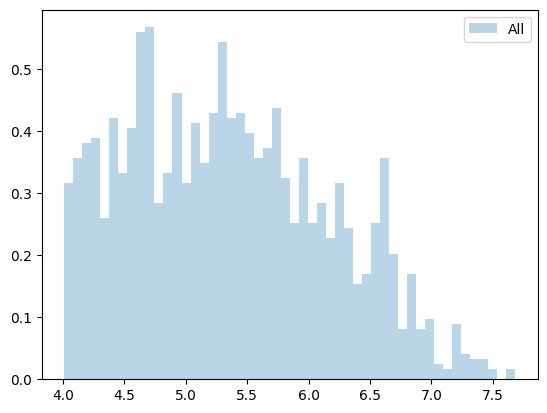

In [26]:
tag = ""
bins = 50
alpha = 0.3
density = True

plt.hist(affinities_all, bins=bins, alpha=alpha, density=density, label="All")
plt.legend(loc='upper right')
plt.show()

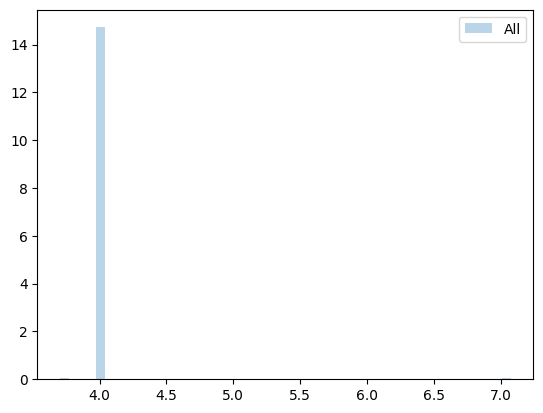

In [27]:
tag = ""
bins = 50
alpha = 0.3
density = True

plt.hist(affinities_add, bins=bins, alpha=alpha, density=density, label="All")
plt.legend(loc='upper right')
plt.show()

In [28]:
affinities_add

[4.002176919254275,
 4.002176919254275,
 nan,
 4.002176919254275,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.004320939488378,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.00436480540245,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.00436480540245,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.00436480540245,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.004233220950026,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 nan,
 4.002176919254275,
 4.002176919254275,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.004233220950026,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 nan,
 4.002176919254275,
 4.002176919254275,
 4.002176919254275,
 4.002176919254

In [19]:
tag = ""
all_affinities = comp_dict["train" + tag]["affinity"] + comp_dict["test" + tag]["affinity"]
min(all_affinities), max(all_affinities)

(4.009710728188184, 7.68204756423876)

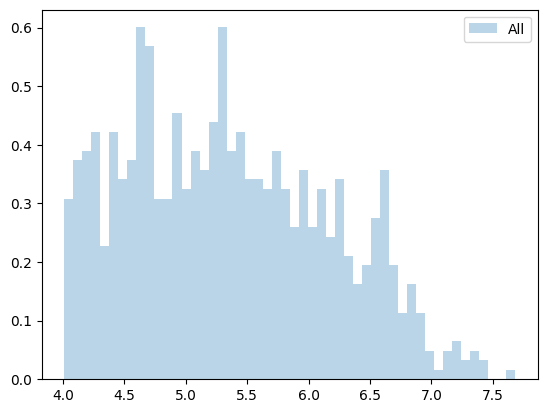

In [20]:
tag = ""
bins = 50
alpha = 0.3
density = True

plt.hist(all_affinities, bins=bins, alpha=alpha, density=density, label="All")
plt.legend(loc='upper right')
plt.show()

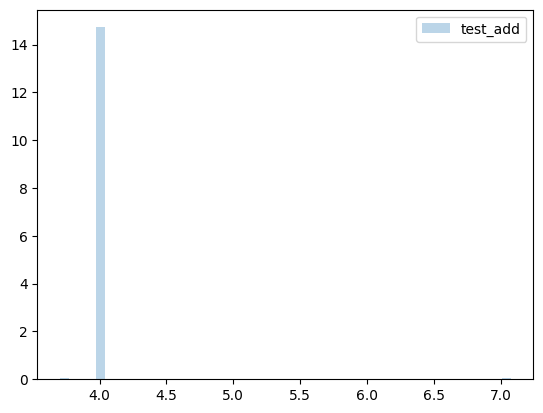

In [24]:
tag = ""
bins = 50
alpha = 0.3
density = True

subset = "test_add"

plt.hist(comp_dict[subset]["affinity"], bins=bins, alpha=alpha, density=density, label=subset)
plt.legend(loc='upper right')
plt.show()

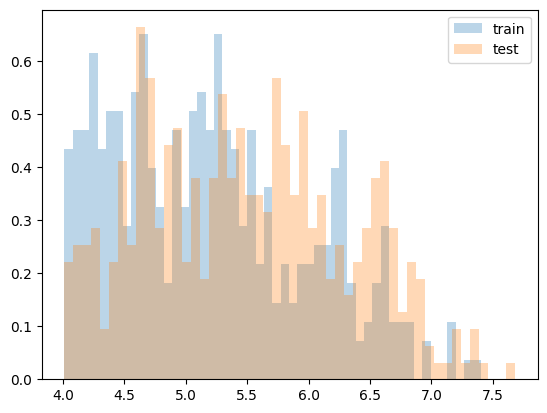

In [21]:
tag = ""
bins = 50
alpha = 0.3
density = True

for subset in ("train", "test"):
    plt.hist(comp_dict[subset + tag]["affinity"], bins=bins, alpha=alpha, density=density, label=subset)
plt.legend(loc='upper right')
plt.show()

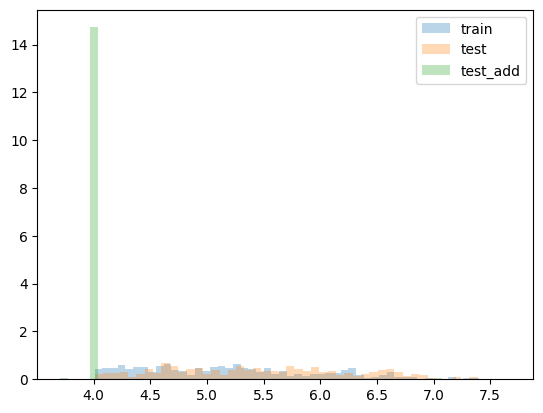

In [23]:
tag = ""
bins = 50
alpha = 0.3
density = True

for subset in ("train", "test", "test_add"):
    plt.hist(comp_dict[subset + tag]["affinity"], bins=bins, alpha=alpha, density=density, label=subset)
plt.legend(loc='upper right')
plt.show()

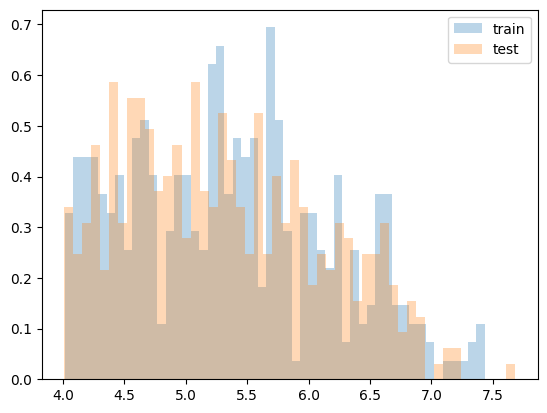

In [22]:
tag = "_random"
bins = 50
alpha = 0.3
density = True

for subset in ("train", "test"):
    plt.hist(comp_dict[subset + tag]["affinity"], bins=bins, alpha=alpha, density=density, label=subset)
plt.legend(loc='upper right')
plt.show()